In [535]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [536]:
def gauss(x, sigma=1):
	g = np.exp(-x**2 / (2*sigma**2)) / (sigma*np.sqrt(2*np.pi))
	return g
def gaussdx_point(w, sigma=1):
	g = -w * np.exp(-w**2 / (2*sigma**2)) / (sigma**3*np.sqrt(2*np.pi))
	return g
def gaussdx2_point(w, sigma=1):
	g = (w**2 - sigma**2) * np.exp(-w**2 / (2*sigma**2)) / (sigma**5*np.sqrt(2*np.pi))
	return g

def gaussian_kernel(sigma):
	tris = np.ceil(3*sigma)
	x = np.arange(-tris, tris+1)
	g = gauss(x, sigma)
	return (g / np.sum(g)).reshape(1, int(2*tris+1))

def gaussdx(sigma):
	tris = np.ceil(3*sigma)
	x = np.arange(-tris, tris+1)
	g = gaussdx_point(x, sigma)
	return (g).reshape(1, int(2*tris+1))

def gaussdx2(sigma):
	tris = np.ceil(3*sigma)
	x = np.arange(-tris, tris+1)
	g = gaussdx2_point(x, sigma)
	return (g).reshape(1, int(2*tris+1))


def gaussian_filter(I, sigma):
	ker = gaussian_kernel(sigma)
	I = cv2.filter2D(I, -1, ker)
	I = cv2.filter2D(I.T, -1, ker)
	return I.T


def partial_d(img, dir="x", sigma=1):
	G = gaussian_kernel(sigma)
	D = gaussdx(sigma)
	if dir == "y":
		G = G.T
		D = D.T

	Id = cv2.filter2D(img, -1, G.T)
	Id = cv2.filter2D(Id, -1, np.flip(D))
	return Id

def partial_2d(img, dir1="x", dir2="x", sigma=1):
	if dir1 != dir2:
		'''I2d = partial_d(img, dir1, sigma/np.sqrt(2))
		I2d = partial_d(I2d, dir2, sigma/np.sqrt(2))
		'''
		D = gaussdx(sigma)
		I2d = cv2.filter2D(img, -1, np.flip(D))
		I2d = cv2.filter2D(I2d, -1, np.flip(D).T)
	else:
		G = gaussian_kernel(sigma)
		D = gaussdx2(sigma)
		if dir1 == "y":
			G = G.T
			D = D.T

		I2d = cv2.filter2D(img, -1, G.T)
		I2d = cv2.filter2D(I2d, -1, np.flip(D))
	#plt.imshow(I2d, cmap="gray")
	#plt.show()
	return I2d

# Exercise 1: Feature points detectors

In [537]:
def nms(I, thr):
	I1 = np.pad(I, 1)
	I2 = np.zeros_like(I1)
	li = []
	lj = []
	for i in range(1, 1+I.shape[0]):
		for j in range(1, 1+I.shape[1]):
			m = I1[i,j]
			if m < thr:
				continue
			
			if m >= np.max(I1[i-1:i+2, j-1:j+2]):
				I2[i,j] = m
				li.append(i-1)
				lj.append(j-1)
	ps = np.array([lj, li])
	return I2[1:-1, 1:-1], ps

def hessian_points(I, sigma=1, thresh=100):
	Ixx = partial_2d(I, "x", "x", sigma)
	Ixy = partial_2d(I, "x", "y", sigma)
	Iyy = partial_2d(I, "y", "y", sigma)

	det =  (Ixx*Iyy - Ixy**2) * sigma**4

	det_nms, ps = nms(det, thresh)
	return det, ps

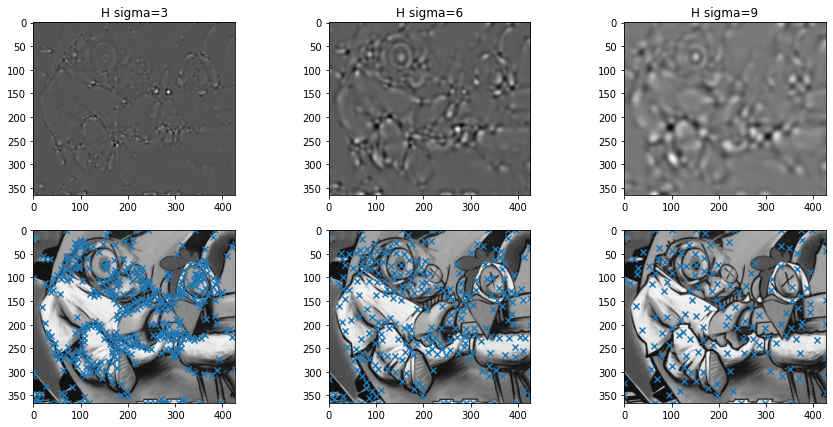

In [538]:
I = cv2.imread("./data/test_points.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY).astype("float")

H1, ps1 = hessian_points(I, 3, 150)
H2, ps2 = hessian_points(I, 6)
H3, ps3 = hessian_points(I, 9)

plt.rcParams["figure.figsize"] = (15,7)

plt.subplot(231)
plt.title("H sigma=3")
plt.imshow(H1, cmap="gray")

plt.subplot(232)
plt.title("H sigma=6")
plt.imshow(H2, cmap="gray")

plt.subplot(233)
plt.title("H sigma=9")
plt.imshow(H3, cmap="gray")


plt.subplot(234)
plt.imshow(I, cmap="gray")
plt.scatter(ps1[0], ps1[1], marker="x")

plt.subplot(235)
plt.imshow(I, cmap="gray")
plt.scatter(ps2[0], ps2[1], marker="x")

plt.subplot(236)
plt.imshow(I, cmap="gray")
plt.scatter(ps3[0], ps3[1], marker="x")

In [539]:
print(ps1.shape)
print(ps2.shape)
print(ps3.shape)
print(np.mean(H1))
print(np.std(H1))

(2, 401)
(2, 257)
(2, 147)
7.5720971542964115
128.50587016809175


Blobs are detected. The larger the sigma, the larger the blobs that are detected.

In [540]:
def harris_points(I, sigma=1, thresh=100):
	sigma_t = 1.6*sigma
	alpha = 0.06
	Ix = partial_d(I, "x", sigma)
	Iy = partial_d(I, "y", sigma)

	C11 = gaussian_filter(Ix**2, sigma_t) * sigma**2
	C12 = gaussian_filter(Ix*Iy, sigma_t) * sigma**2
	C22 = gaussian_filter(Iy**2, sigma_t) * sigma**2

	det =  (C11*C22 - C12**2)
	tr = C11 + C22

	c = det - alpha*tr**2

	c_nms, ps = nms(det, thresh)
	return c, ps

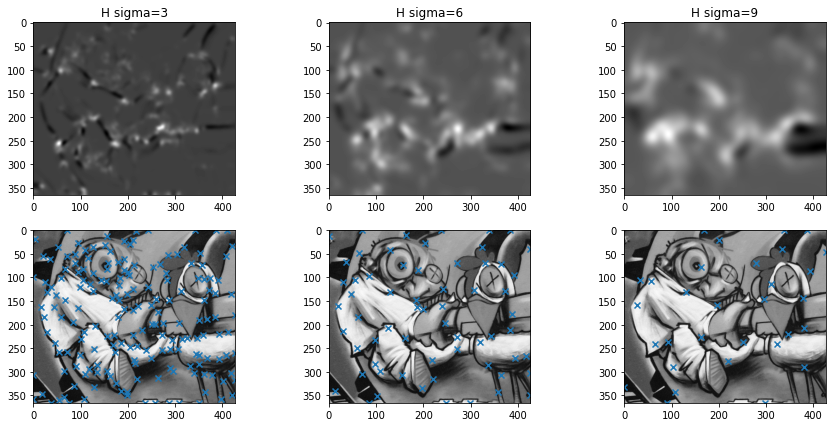

In [541]:
I = cv2.imread("./data/test_points.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY).astype("float")

H1, ps1 = harris_points(I, 3)
H2, ps2 = harris_points(I, 6)
H3, ps3 = harris_points(I, 9)

plt.rcParams["figure.figsize"] = (15,7)

plt.subplot(231)
plt.title("H sigma=3")
plt.imshow(H1, cmap="gray")

plt.subplot(232)
plt.title("H sigma=6")
plt.imshow(H2, cmap="gray")

plt.subplot(233)
plt.title("H sigma=9")
plt.imshow(H3, cmap="gray")


plt.subplot(234)
plt.imshow(I, cmap="gray")
plt.scatter(ps1[0], ps1[1], marker="x")

plt.subplot(235)
plt.imshow(I, cmap="gray")
plt.scatter(ps2[0], ps2[1], marker="x")

plt.subplot(236)
plt.imshow(I, cmap="gray")
plt.scatter(ps3[0], ps3[1], marker="x")

In [542]:
print(ps1.shape)
print(ps2.shape)
print(ps3.shape)

(2, 180)
(2, 63)
(2, 31)


---
# Exercise 2: Matching local regions

In [543]:
import a4_utils

def display_matches(im1, im2, pts1, pts2, matches): ### from a4_utils

	# NOTE: this will only work correctly for images with the same height
	# NOTE: matches should contain index pairs (i.e. first element is the index to pts1 and second for pts2)

	I = np.hstack((im1,im2))
	w = im1.shape[1]
	plt.imshow(I, cmap="gray")
	
	for i, j in matches:
		p1 = pts1[int(i)]
		p2 = pts2[int(j)]
		plt.plot(p1[0], p1[1], 'bo')
		plt.plot(p2[0]+w, p2[1], 'bo')
		plt.plot([p1[0], p2[0]+w], [p1[1], p2[1]], 'r')

In [544]:
def hellinger(h1, h2):
	return np.sqrt(np.sum((np.sqrt(h1) - np.sqrt(h2))**2)/2)

def find_correspondences(d1, d2):
	sims = np.zeros((d1.shape[0], d2.shape[0]))
	for i in range(d1.shape[0]):
		for j in range(d2.shape[0]):
			sims[i, j] = hellinger(d1[i], d2[j])
			
	pairs_from_1 = []
	for i in range(d1.shape[0]):
		pairs_from_1.append((i, np.argmin(sims[i])))
	return pairs_from_1
	

In [545]:
I1 = cv2.imread("./data/graf/graf1_small.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY).astype("float")

I2 = cv2.imread("./data/graf/graf2_small.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY).astype("float")

I1 = I1[:I2.shape[0], :]

H1, ps1 = harris_points(I1, 3)
H2, ps2 = harris_points(I2, 3)

d1 = a4_utils.simple_descriptors(I1, ps1.T)
d2 = a4_utils.simple_descriptors(I2, ps2.T)
c = find_correspondences(d1, d2)

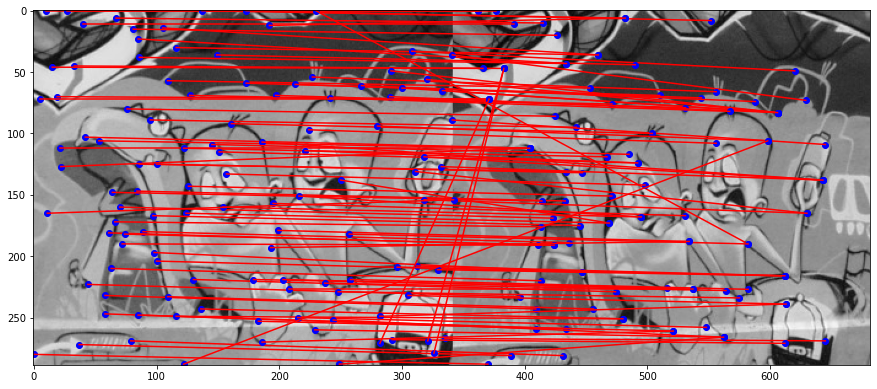

In [546]:
display_matches(I1, I2, ps1.T, ps2.T, c)

Larger radius better but slower, larger w is worse. Too small number of bins is worse

In [547]:
len(c)

111

In [548]:
def find_matches(I1, I2, sigma=3):
	H1, ps1 = harris_points(I1, sigma)
	H2, ps2 = harris_points(I2, sigma)

	d1 = a4_utils.simple_descriptors(I1, ps1.T)
	d2 = a4_utils.simple_descriptors(I2, ps2.T)

	sims = np.zeros((d1.shape[0], d2.shape[0]))
	for i in range(d1.shape[0]):
		for j in range(d2.shape[0]):
			sims[i, j] = hellinger(d1[i], d2[j])
			
	pairs_from_1 = []
	for i in range(d1.shape[0]):
		j = np.argmin(sims[i])
		if i == np.argmin(sims[:,j]):
			pairs_from_1.append((i, j))
	
	return pairs_from_1, ps1, ps2

In [549]:
I1 = cv2.imread("./data/graf/graf1_small.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY).astype("float")

I2 = cv2.imread("./data/graf/graf2_small.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY).astype("float")
I1 = I1[:I2.shape[0], :]

c, ps1, ps2 = find_matches(I1, I2)

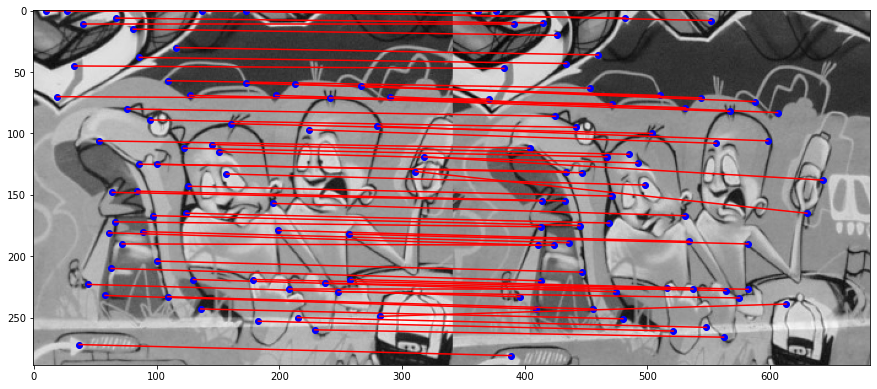

In [550]:
display_matches(I1, I2, ps1.T, ps2.T, c)

The matches are way more robust than before.

In [551]:
print(2*len(c) / (ps1.shape[1] + ps2.shape[1]))

0.5560538116591929


---
# BONUS

In [552]:
def gradient_magnitude(img, sigma=1):
	Ix = partial_d(img, "x", sigma)
	Iy = partial_d(img, "y", sigma)
	m = np.sqrt(Ix**2 + Iy**2)
	phi = np.arctan2(Iy, Ix)
	return m, phi

def correlation(h1, h2):
	return np.sum(h1*h2) / (len(h1) * np.std(h1) * np.std(h1))

In [553]:
def sift_descriptor(region_mag, region_dir, rotation=0, bin_size=4):
	off = bin_size*2
	hist = np.zeros((4,4,8))
	
	pi4 = np.pi/4
	for i in range(4):
		for j in range(4):
			c_mag = region_mag[bin_size*(i-2):(bin_size*(i-1)), bin_size*(j-2):(bin_size*(j-1))]
			c_dir = region_dir[bin_size*(i-2):(bin_size*(i-1)), bin_size*(j-2):(bin_size*(j-1))]
			c_dir = np.mod(c_dir + rotation + pi4/2, 2*np.pi)
			for k in range(8):
				hist[i,j,k] = np.sum(c_mag[(c_dir >= pi4*k) * (c_dir < pi4*(k+1))])
	
	h = hist.flatten()
	h = h / np.sum(h)
	h = np.clip(h, 0, 0.2)
	h = h / np.sum(h)
	return h


In [554]:
def sift_descriptors(I, pts, bin_size=4):
	off = bin_size*2
	Imag, Idir = gradient_magnitude(I)
	Imag = np.pad(Imag, off)
	Idir = np.pad(Idir, off)

	ds = []
	for point in pts.T:
		point = np.flip(point)

		g = gauss(np.linspace(-1, 1, bin_size*4), 0.5)
		g = g.reshape(1, len(g))
		g = g / np.sum(g)

		region_mag = Imag[(-bin_size*2 + off + point[0]):(bin_size*2 + off + point[0]), (-bin_size*2 + off + point[1]):(bin_size*2 + off + point[1])]
		region_mag = (region_mag * g) * g.T
		region_dir = Idir[(-bin_size*2 + off + point[0]):(bin_size*2 + off + point[0]), (-bin_size*2 + off + point[1]):(bin_size*2 + off + point[1])]

		grad_hist = np.zeros(36)
		pi18 = np.pi/18
		for k in range(36):
			grad_hist[k] = np.sum(region_mag[(region_dir >= pi18*k) * (region_dir < pi18*(k+1))])
		hist_max = np.max(grad_hist)
		d = []
		for k in range(len(grad_hist)):
			if (grad_hist[k] >= 0.8*hist_max):
				rot = np.pi*k/18 - np.pi
				d.append(sift_descriptor(region_mag, region_dir, rotation=-rot))
		ds.append(d)
	return ds

In [555]:
I1 = cv2.imread("./data/graf/graf1_small.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY).astype("float")

I2 = cv2.imread("./data/graf/graf2_small.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY).astype("float")

I1 = I1[:I2.shape[0], :]

H1, ps1 = hessian_points(I1, 3, 150)
H2, ps2 = hessian_points(I2, 3, 150)


In [556]:
d1 = sift_descriptors(I1, ps1)
d2 = sift_descriptors(I2, ps2)

In [557]:
sims = np.zeros((len(d1), len(d2))).astype("float")
for i in range(len(d1)):
	for j in range(len(d2)):
		for dd1 in d1[i]:
			for dd2 in d2[j]:
				sims[i, j] = np.maximum(hellinger(dd1, dd2), sims[i,j])

pairs_from_1 = []
for i in range(len(d1)):
	j = np.argmin(sims[i])
	if i == np.argmin(sims[:,j]):
		pairs_from_1.append((i, j))

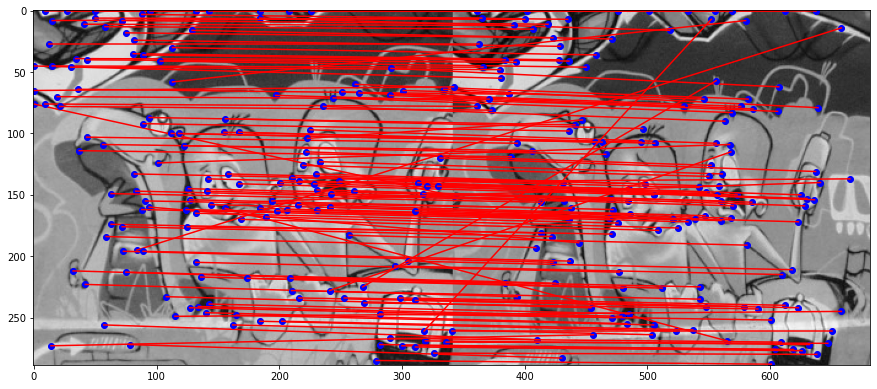

In [558]:
display_matches(I1, I2, ps1.T, ps2.T, pairs_from_1)

In [559]:
print(len(pairs_from_1))

152


# Exercise 3: Homography estimation

p2 and p4 translation, p1 and p2 roatation & scale



In [560]:
def estimate_homography(ps1, ps2, cs):
	A = np.zeros((2*len(cs), 9))
	for i in range(len(cs)):
		r = ps1[cs[i][0]]
		t = ps2[cs[i][1]]
		A[2*i] = [r[0], r[1], 1, 0, 0, 0, -t[0]*r[0], -t[0]*r[1], -t[0]]
		A[2*i + 1] = [0, 0, 0, r[0], r[1], 1, -t[1]*r[0], -t[1]*r[1], -t[1]]
	
	[U, S, V] = np.linalg.svd(A, False)
	V = V.T
	h = V[:, np.argmin(S)] / V[-1,np.argmin(S)]
	return h.reshape(3,3)

In [561]:
def read_data(filename): # iz a2_utils
	# reads a numpy array from a text file
	with open(filename) as f:
		s = f.read()

	return np.fromstring(s, sep=' ')

def read_points(filename):
	pts = read_data(filename)
	ps = []
	for i in range(int(len(pts) / 4)):
		ps.append([pts[j] for j in range(i*4, 4*i+4)])

	ps1 = [[p[0], p[1]] for p in ps]
	ps2 = [[p[2], p[3]] for p in ps]

	corresps = [[0,0],[1,1],[2,2],[3,3]]
	return ps1, ps2, corresps

In [562]:
I1 = cv2.imread("./data/newyork/newyork1.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)

I2 = cv2.imread("./data/newyork/newyork2.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

ps1, ps2, corresps = read_points("./data/newyork/newyork.txt")

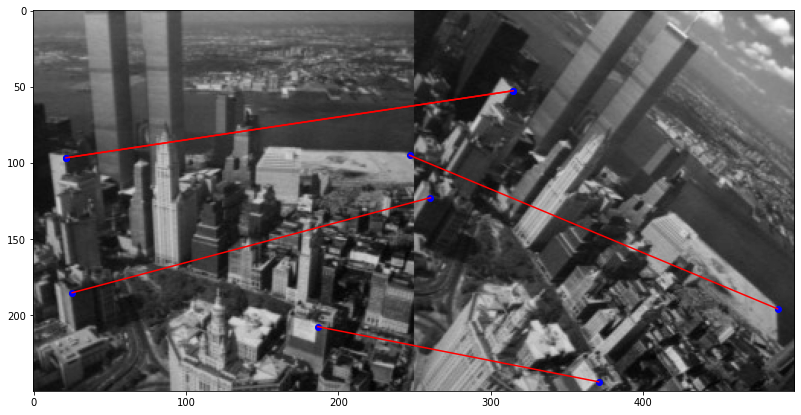

In [563]:
corresps.append([0,0])
display_matches(I1, I2, ps1, ps2, corresps)

In [564]:
H = estimate_homography(ps1, ps2, corresps)

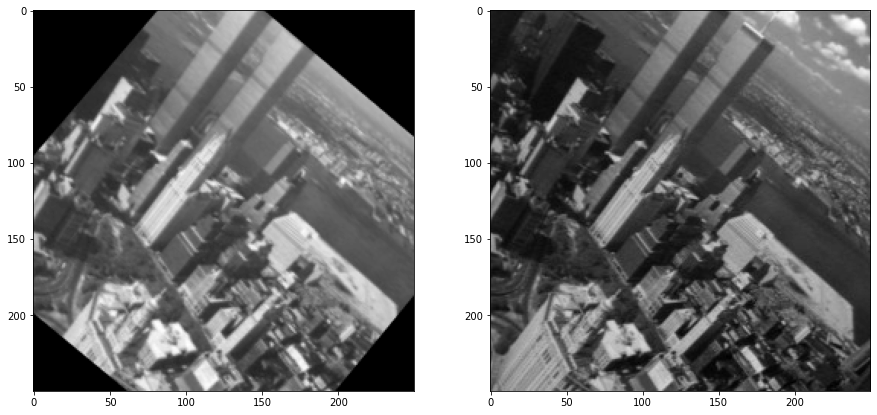

In [565]:
I1w = cv2.warpPerspective(I1, H, dsize=I2.T.shape)
plt.subplot(121)
plt.imshow(I1w, cmap="gray")
plt.subplot(122)
plt.imshow(I2, cmap="gray")

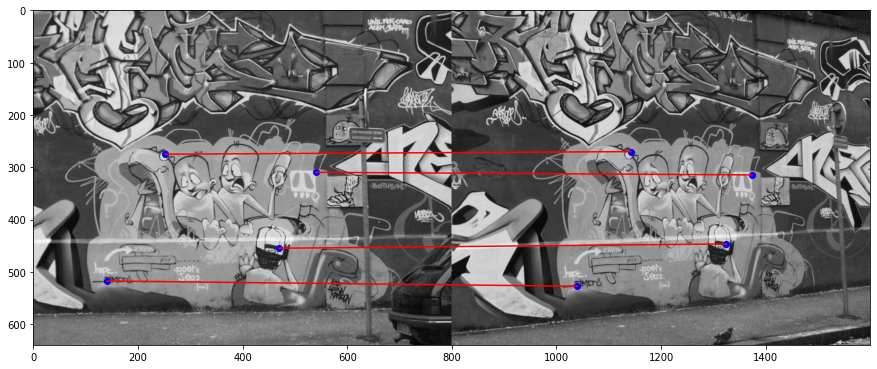

In [566]:
I1 = cv2.imread("./data/graf/graf1.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)

I2 = cv2.imread("./data/graf/graf2.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

ps1, ps2, corresps = read_points("./data/graf/graf.txt")

display_matches(I1, I2, ps1, ps2, corresps)

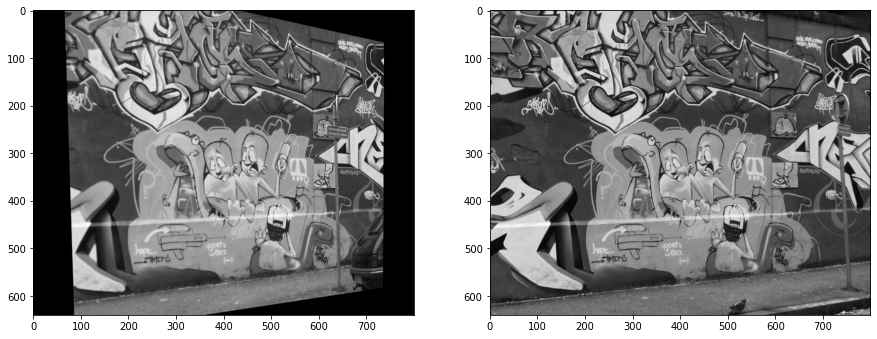

In [567]:
corresps.append([0,0])
H = estimate_homography(ps1, ps2, corresps)
I1w = cv2.warpPerspective(I1, H, dsize=I2.T.shape)
plt.subplot(121)
plt.imshow(I1w, cmap="gray")
plt.subplot(122)
plt.imshow(I2, cmap="gray")

In [568]:
def find_matches2(I1, I2, sigma=3):
	H1, ps1 = harris_points(I1, sigma)
	H2, ps2 = harris_points(I2, sigma)

	d1 = a4_utils.simple_descriptors(I1, ps1.T)
	d2 = a4_utils.simple_descriptors(I2, ps2.T)

	sims = np.zeros((d1.shape[0], d2.shape[0]))
	for i in range(d1.shape[0]):
		for j in range(d2.shape[0]):
			sims[i, j] = hellinger(d1[i], d2[j])
			
	pairs_from_1 = []
	simil = []
	for i in range(d1.shape[0]):
		j = np.argmin(sims[i])
		if i == np.argmin(sims[:,j]):
			pairs_from_1.append((i, j))
			simil.append((sims[i,j]**2/np.sum(sims[i,:]) * sims[i,j]**2/np.sum(sims[:,j])))
	
	return pairs_from_1, simil, ps1, ps2

In [569]:
I1 = cv2.imread("./data/newyork/newyork1.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY).astype("float")

I2 = cv2.imread("./data/newyork/newyork2.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY).astype("float")
I1 = I1[:I2.shape[0], :]

c, sims, ps1, ps2 = find_matches2(I1, I2)
c = np.array(c)
sims=np.array(sims)
ps1 = ps1.T
ps2 = ps2.T

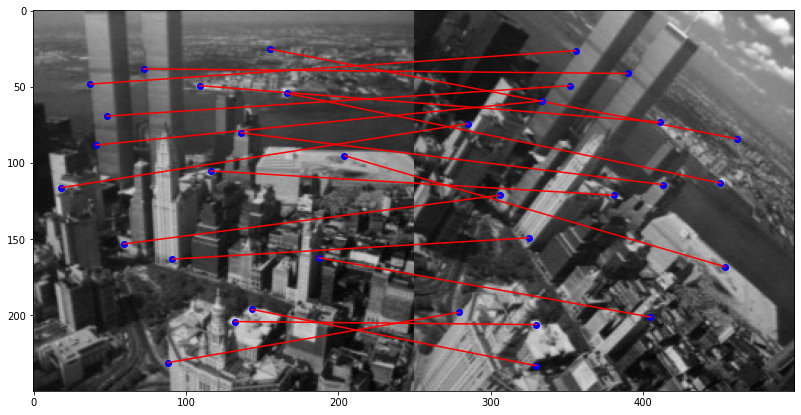

In [570]:
ord = np.argsort(-sims)
cc = c[ord[3:20]]
display_matches(I1, I2, ps1, ps2, cc)

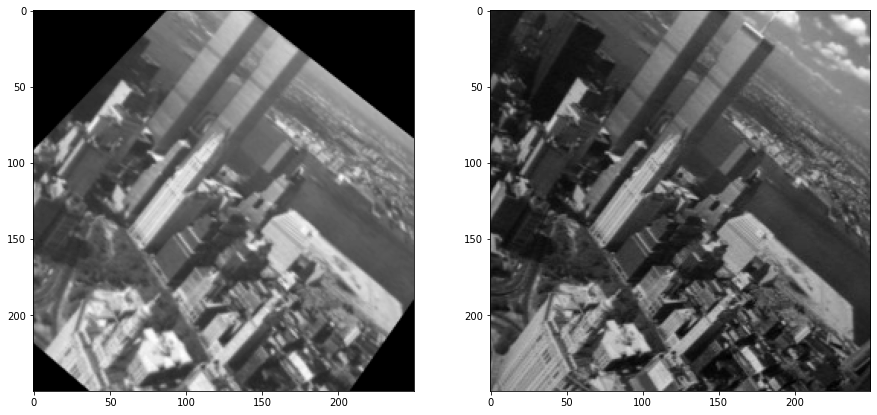

In [571]:
H = estimate_homography(ps1, ps2, list(cc))
I1w = cv2.warpPerspective(I1, H, dsize=I2.T.shape)
plt.subplot(121)
plt.imshow(I1w, cmap="gray")
plt.subplot(122)
plt.imshow(I2, cmap="gray")

In [572]:
I1 = cv2.imread("./data/graf/graf1_small.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY).astype("float")

I2 = cv2.imread("./data/graf/graf2_small.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY).astype("float")
I1 = I1[:I2.shape[0], :]

c, sims, ps1, ps2 = find_matches2(I1, I2)
c = np.array(c)
sims=np.array(sims)
ps1 = ps1.T
ps2 = ps2.T

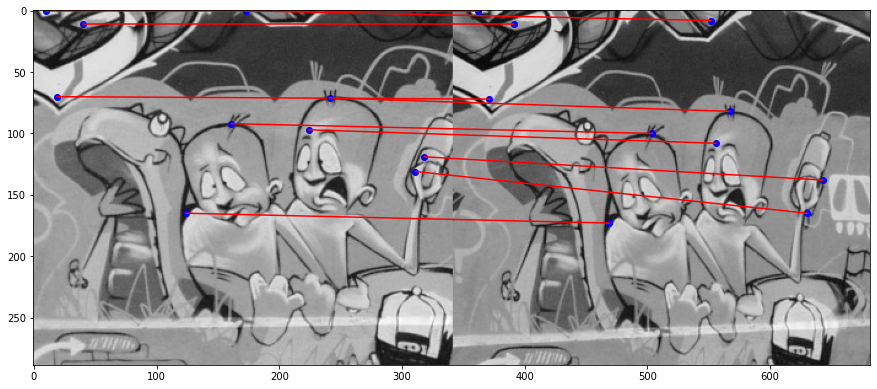

In [573]:
ord = np.argsort(-sims)
cc = c[ord[5:15]]
display_matches(I1, I2, ps1, ps2, cc)

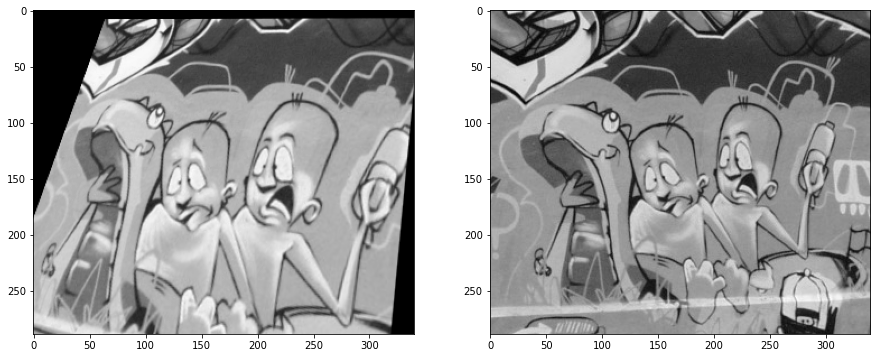

In [574]:
H = estimate_homography(ps1, ps2, list(cc))
I1w = cv2.warpPerspective(I1, H, dsize=I2.T.shape)
plt.subplot(121)
plt.imshow(I1w, cmap="gray")
plt.subplot(122)
plt.imshow(I2, cmap="gray")